## Importaciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

from ipywidgets import interact
import plotly.express as px
import ipywidgets as widgets

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sodapy import Socrata

### Definición de funciones


In [2]:
#Definición de funciones

#Formula para evaluar modelos:
def get_error_percentage(real_it, predicted_it):
    #cuanto más cerca del 0 mejor
    print("get_error_percentage() method was called.")
    rmse = math.sqrt(mean_squared_error(real_it, 
    predicted_it))
    error_percentage = rmse / np.average(real_it)
    return error_percentage

In [32]:
def analisis_adfuller(ts):
    if adfuller(ts)[1]>0.05:
        return f'Rechazamos la Ho porque {adfuller(ts)[1]} es mayor que 0.05. Por tanto, la señal es estacionaria'
    else:
        return f'La señal no es estacionaria'

### Dataset

In [3]:
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")

In [4]:
#comprobamos los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    230 non-null    int64  
 1   COLECTIVO                230 non-null    object 
 2   mes                      230 non-null    int64  
 3   año                      230 non-null    int64  
 4   Festivos_intersemanales  230 non-null    int64  
 5   Plantilla                230 non-null    float64
 6   Plantilla_de_baja        230 non-null    float64
 7   date                     230 non-null    object 
 8   casos_covid              230 non-null    float64
 9   busquedas_google         230 non-null    float64
 10  cambio_normativa         230 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 19.9+ KB


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
#Elimino columnas no relevantes para análisis de series temporales
df.drop(['index','COLECTIVO','mes','año'],axis=1,inplace=True)

## Feature selection

In [7]:
#definimos X e y:
X=df.drop(['Plantilla_de_baja','date'],axis=1)
y=df['Plantilla_de_baja']

In [8]:
#seleccion de columnas a partir de modelo
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X,y)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=1000))

In [9]:
X.columns[(sel.get_support())]

Index(['Plantilla', 'casos_covid'], dtype='object')

El feature selection form model de Random Forest sugiere sólo considerar las variables 'Plantilla' y 'Casos_covid'

## Análisis de series temporales

### Visualizacion componentes de seasonal descompose

In [30]:
ts=df.set_index('date')
ts_it=ts[['Plantilla_de_baja']]
ts_covid=ts[['casos_covid']][-24:] #desde marzo 2020
ts_plantilla=ts[['Plantilla']]
ts_google=ts[['busquedas_google']][32:] #desde octubre de 2005

'Rechazamos la Ho porque 0.06482179486403275 es mayor que 0.05. Por tanto, la señal es estacionaria'

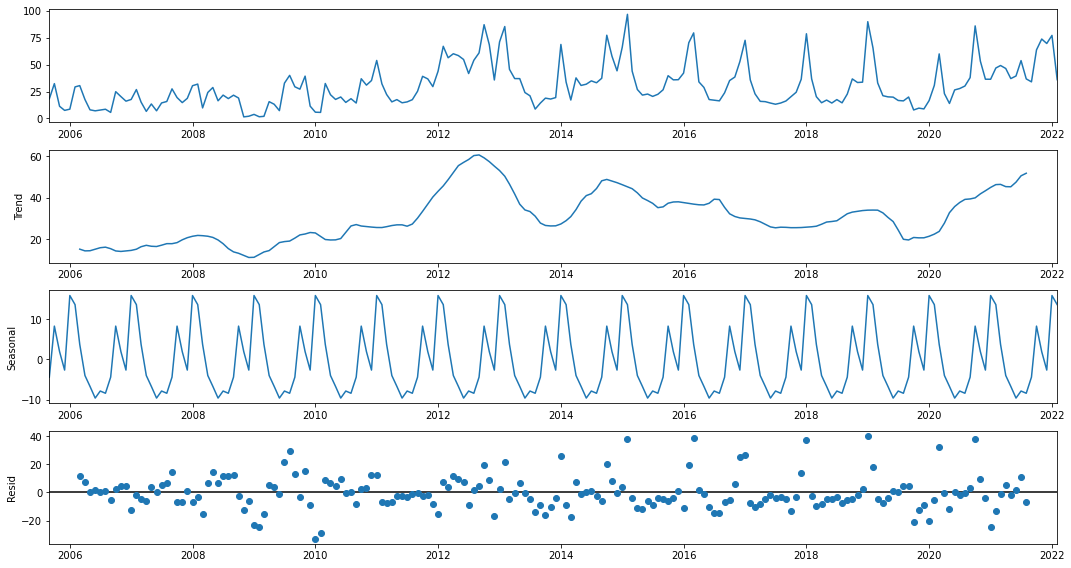

In [34]:
#Analizamos estacionalidad de busquedas en google
plt.rcParams['figure.figsize']=(15,8)

decomposition=seasonal_decompose(ts_google)
_=decomposition.plot()

analisis_adfuller(ts_google)


'Rechazamos la Ho porque 0.17845548292375096 es mayor que 0.05. Por tanto, la señal es estacionaria'

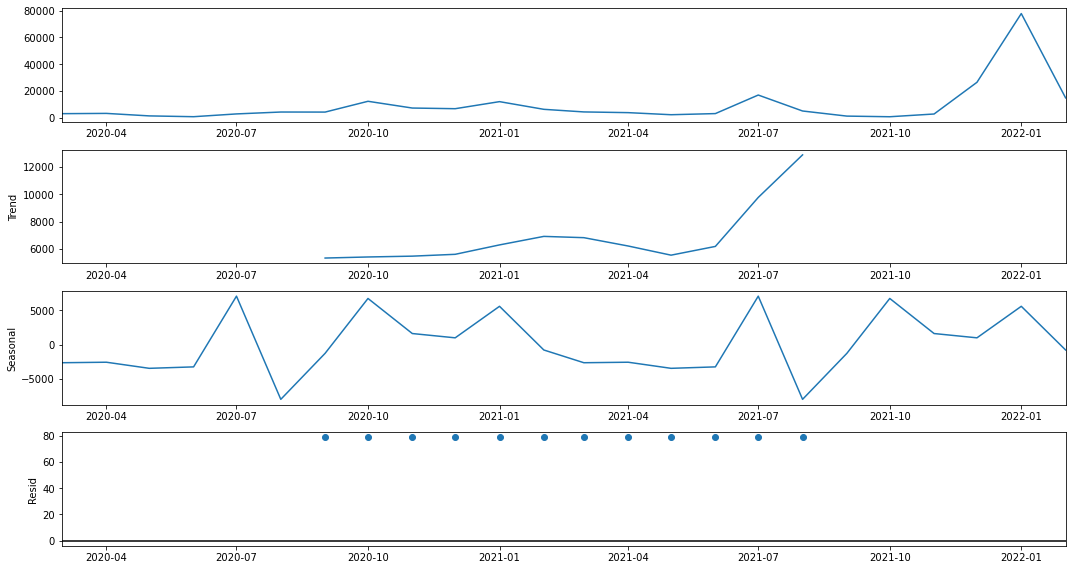

In [35]:
#Analizamos estacionalidad de casos covid
decomposition=seasonal_decompose(ts_covid)
_=decomposition.plot()

analisis_adfuller(ts_covid)

'Rechazamos la Ho porque 0.9765228601891162 es mayor que 0.05. Por tanto, la señal es estacionaria'

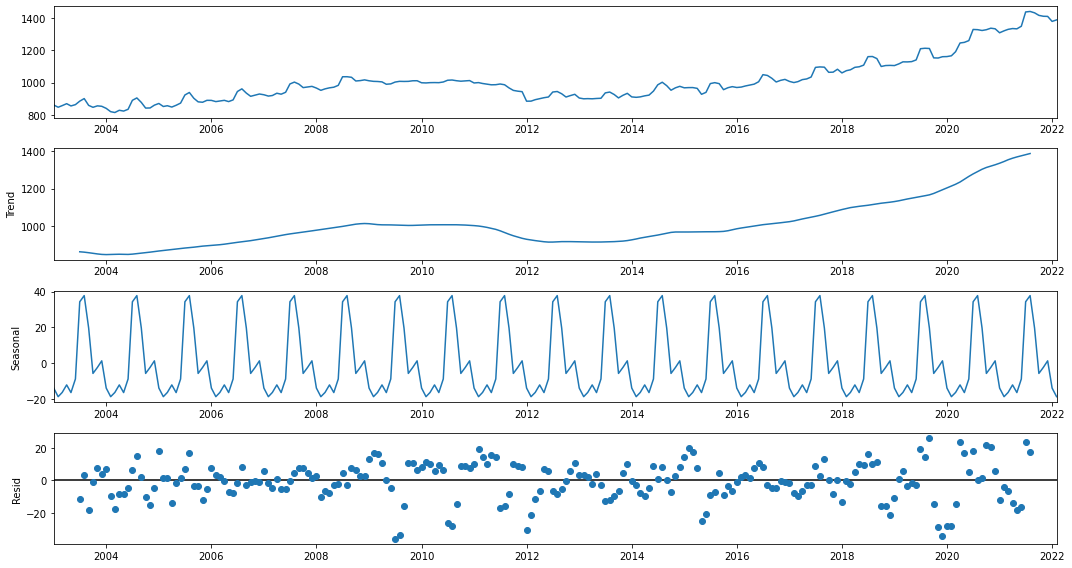

In [36]:
#Analizamos estacionalidad de busquedas en plantilla
decomposition=seasonal_decompose(ts_plantilla)
_=decomposition.plot()

analisis_adfuller(ts_plantilla)

'Rechazamos la Ho porque 0.26546786156435415 es mayor que 0.05. Por tanto, la señal es estacionaria'

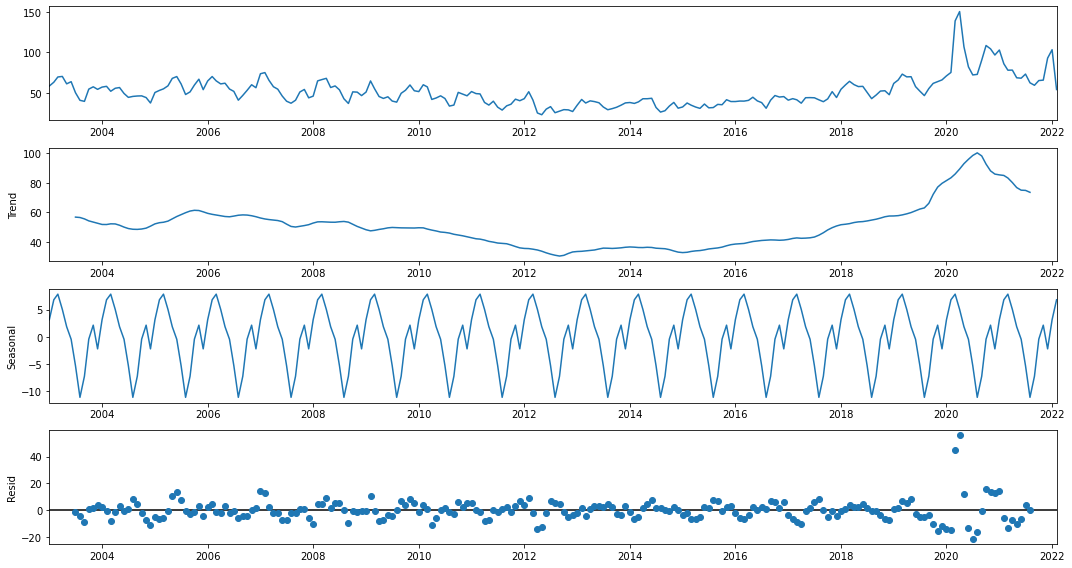

In [37]:
#Analizamos estacionalidad de busquedas en plantilla de it
decomposition=seasonal_decompose(ts_it)
_=decomposition.plot()

analisis_adfuller(ts_it)

### Funciones ACF/PACF

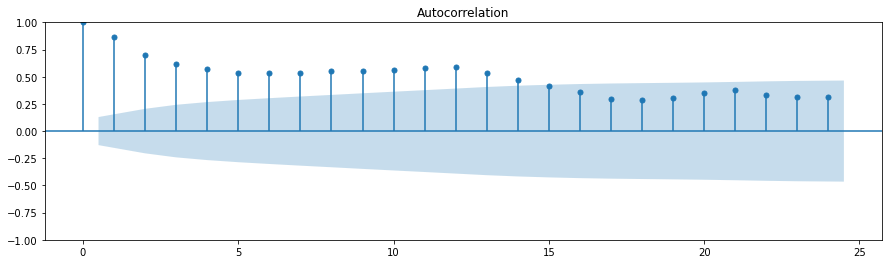

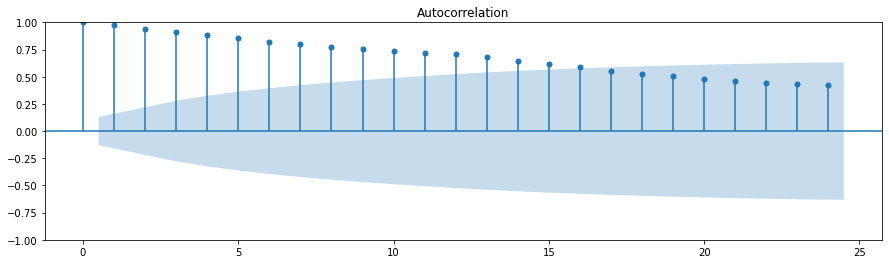

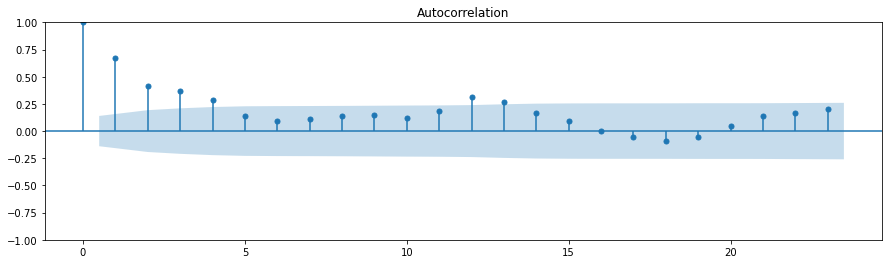

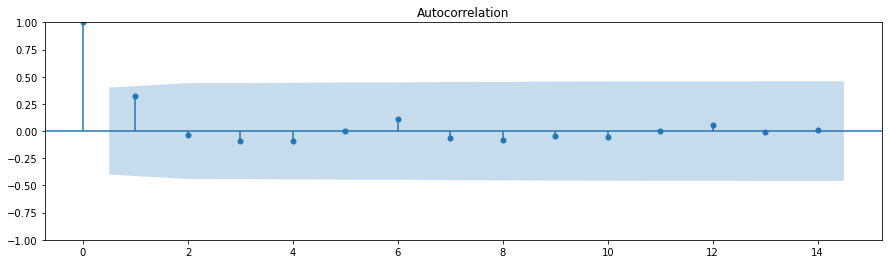

In [54]:
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i)

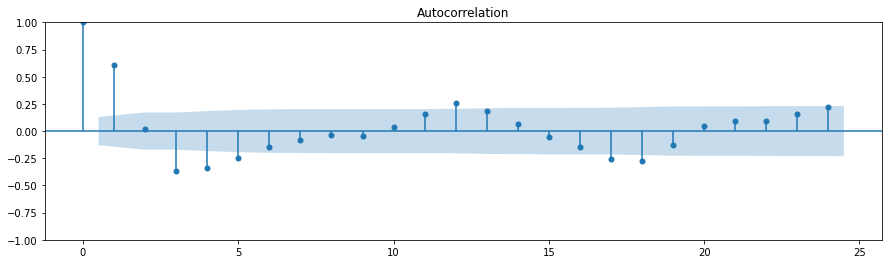

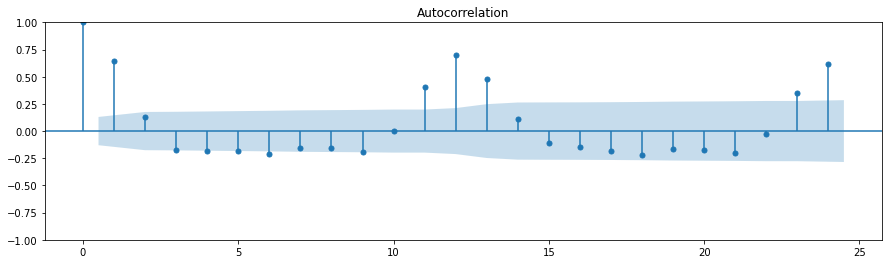

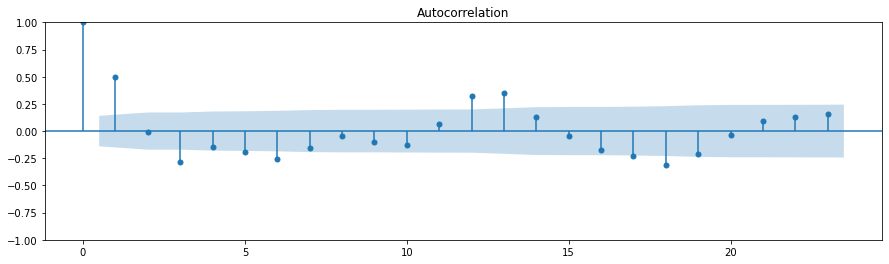

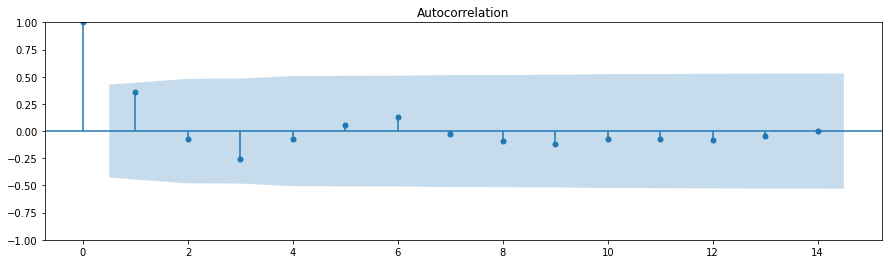

In [58]:
#diferenciación de 3 para ver más clara la estacionalidad
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i.diff(3).dropna())

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 14 must be < 12.

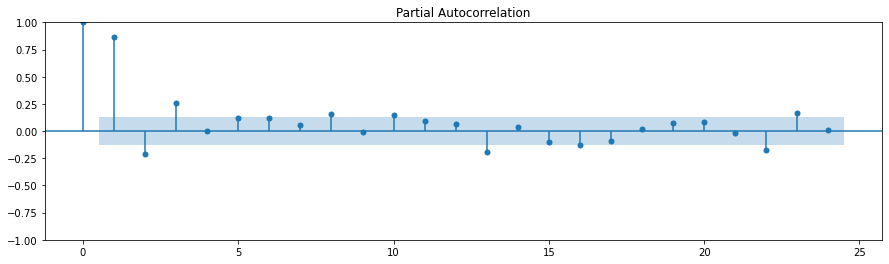

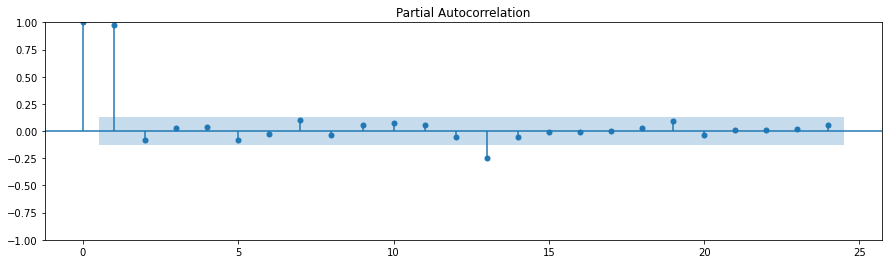

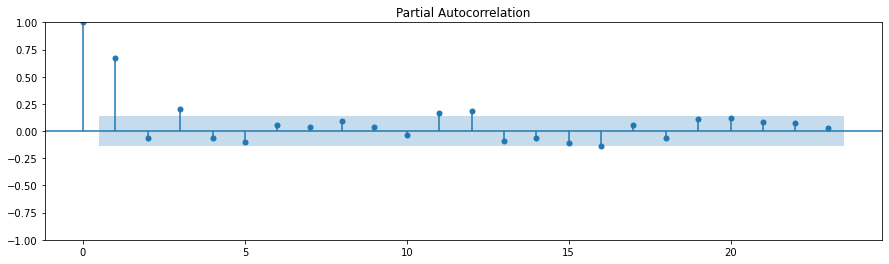

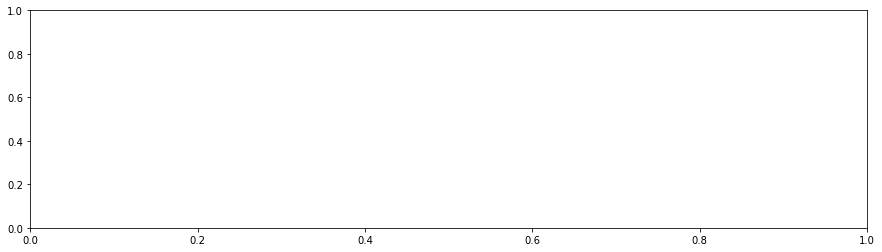

In [59]:
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_pacf(i, method='ywm')

### Conclusiones
* Se observa estacionaridad de 12 meses de la variable plantilla de it.
* Se observa estacionaridad de 12 meses de la variable plantilla.
* Se observa estacionaridad de 12 meses de la variable búsquedas google.
* No se observa estacionaridad en la variable casos covid

## Selección de modelo

### Modelos sin variables exógenas

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.49 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.53 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.93 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.1565102310814885'

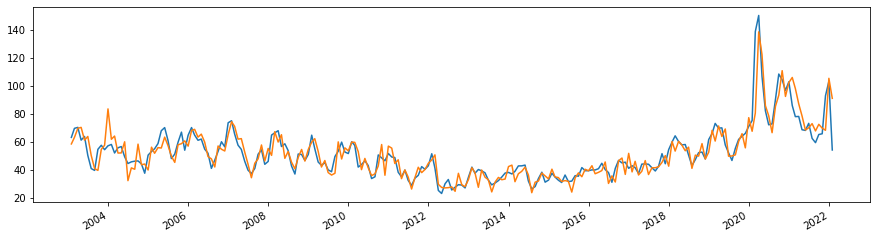

In [60]:
#Obtener mejor modelo de Arima
model1=auto_arima(ts_it, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model1.order 
sparams = model1.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel1 = SARIMAX(ts_it, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results1=smodel1.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts_it[1:])
y_pred_SAR1=results1.get_prediction(start='2003-02-01',end='2022-02-01').predicted_mean
y_pred_SAR1.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_it[1:],y_pred_SAR1)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

In [67]:
#Clasificamos modelo
ranking_modelos=[]
tuple=('smodel1','Sarimax sin exógenos',porc_error_SARIMAX,sparams)
ranking_modelos.append(tuple)

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.20320581873578303'

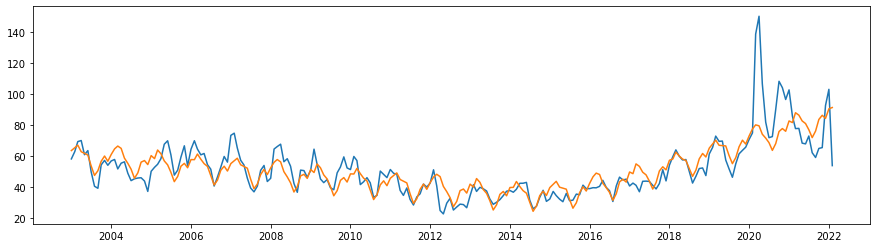

In [64]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model2=Prophet() 
#transformación requerida
prf=ts_it.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#entrenamos modelo
model2.fit(prf)
#obtenemos valores de predicciones
yhat=model2.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_it)
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_it,y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

In [68]:
#Clasificamos modelo
tuple=('model2','Prophet sin exógenos',porc_error_PROPHET,'')
ranking_modelos.append(tuple)

,Modelo,Descripción,Score,Sparams
0,smodel1,Sarimax sin exógenos,0.156510,"(1, 1, 5, 12)"
1,model2,Prophet sin exógenos,0.203206,
2,smodel3,Sarimax con exógeno plantilla,0.151552,"(1, 1, 5, 12)"
3,smodel3b,Sarimax con exógeno plantilla y casos_covid,0.141948,"(1, 1, 5, 12)"
4,smodel4,Sarimax con todos los exógenos (menos casos_co...,0.146623,"(1, 1, 5, 12)"


### Modelos con variables exógenas

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.44 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.68 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.15155244370444557'

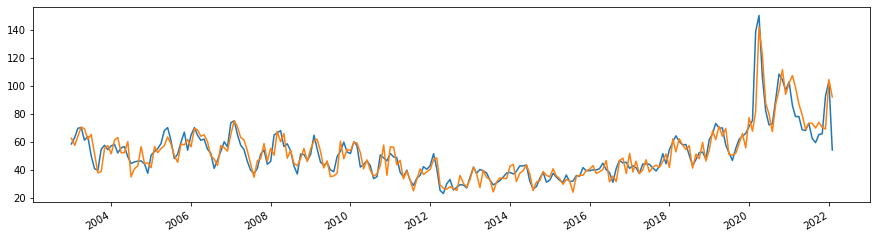

In [73]:
#Obtener mejor modelo de Arima
#Usamos como variables exógenas las sugeridas por random forest (No incluimos casos_covid porque no se puede predecir con time series)
exogenas=ts[['Plantilla']]
model3=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)
model3=auto_arima(ts[['Plantilla_de_baja']], trace=True)
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model3.order 
sparams = model3.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel3 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results3=smodel3.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR3=results3.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR3.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX2=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR3)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX2}'


In [74]:
#Clasificamos modelo
tuple=('smodel3','Sarimax con exógeno plantilla',porc_error_SARIMAX2,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.46 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.45 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.78 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.14194791072228088'

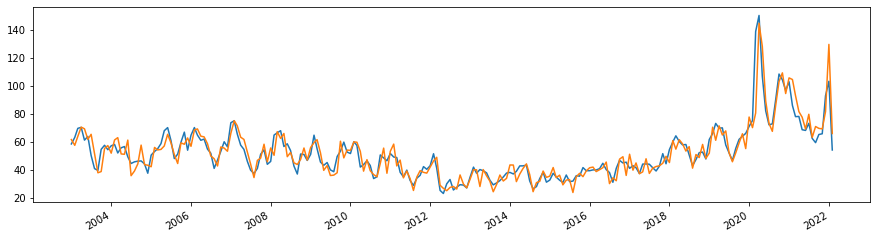

In [76]:
#Obtener mejor modelo de Arima
#Usamos como  variables exógenas todas las sugeridas por random forest 
exogenas=ts[['Plantilla','casos_covid']]
model3b=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model3b.order 
sparams = model3b.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel3b = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results3=smodel3b.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR3b=results3.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR3b.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX2b=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR3b)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX2b}'


In [77]:
#Clasificamos modelo
tuple=('smodel3b','Sarimax con exógeno plantilla y casos_covid',porc_error_SARIMAX2b,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.54 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.53 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.89 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.14662285680206563'

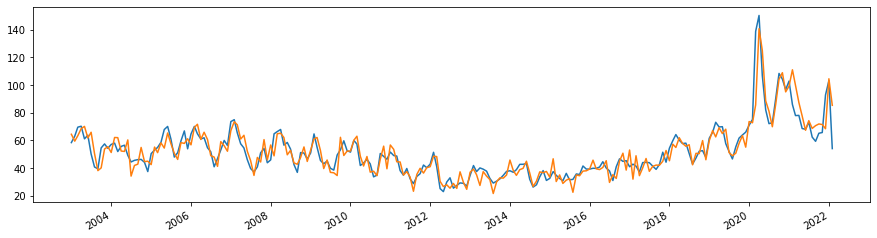

In [80]:
#Obtener mejor modelo de Arima 
#Usamos como variables exógenas todas las variables con no son la objetivo ni casos covid (pq no se puede predecir con time series)
exogenas=ts.drop(['Plantilla_de_baja','casos_covid'],axis=1)
model4=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model4.order 
sparams = model4.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel4 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results4=smodel4.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR4=results4.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR4.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX3=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR4)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX3}'

In [81]:
#Clasificamos modelo
tuple=('smodel4','Sarimax con todos los exógenos (menos casos_covid)',porc_error_SARIMAX3,sparams)
ranking_modelos.append(tuple)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1628.428, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1673.526, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.579, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1664.325, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.527, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1627.818, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1642.732, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.682, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1626.931, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.115, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1627.060, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1620.536, Time=0.39 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1620.577, Time=0.38 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1619.387, Time=0.49 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 5, 12) y un porcentaje de error del 0.14662285680206563'

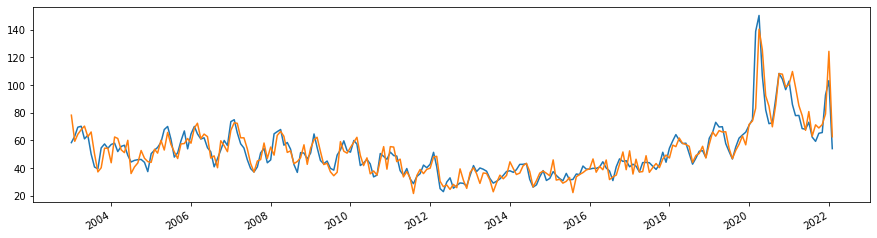

In [108]:
#Obtener mejor modelo de Arima 
#Usamos como variables exógenas todas las variables con no son la objetivo
exogenas=ts.drop(['Plantilla_de_baja'],axis=1)
model5=auto_arima(ts[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model5.order 
sparams = model5.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel5 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results5=smodel5.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts['Plantilla_de_baja'])
y_pred_SAR5=results5.get_prediction(start='2003-01-01',end='2022-02-01').predicted_mean
y_pred_SAR5.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX4=get_error_percentage(ts_it['Plantilla_de_baja'],y_pred_SAR5)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX3}'

In [109]:
#Clasificamos modelo
tuple=('smodel5','Sarimax con todos los exógenos',porc_error_SARIMAX4,sparams)
ranking_modelos.append(tuple)

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.20191739288030539'

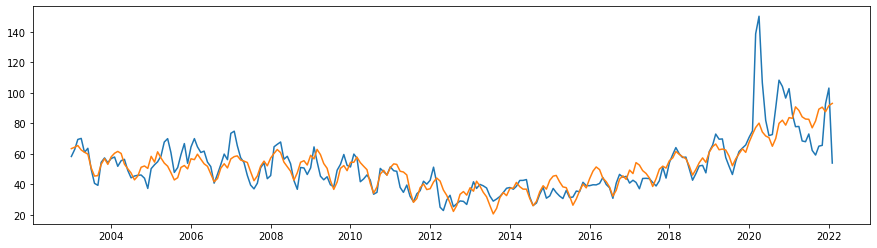

In [83]:
# Obtener modelo con Fbprophet usando variables exógenas recomendadas por Random Forest (salvo covid)
#instanciamos prophet
model5=Prophet() 
#transformación requerida
prf=ts.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#anadimos la exógena
model5.add_regressor('Plantilla')
#model5.add_regressor('casos_covid')
#entrenamos modelo
model5.fit(prf)
#obtenemos valores de predicciones
yhat=model5.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts['Plantilla_de_baja'])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET2=get_error_percentage(ts['Plantilla_de_baja'],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET2}'

In [84]:
#Clasificamos modelo
tuple=('model5','Prophet con exógeno plantilla',porc_error_PROPHET2,'')
ranking_modelos.append(tuple)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.19841538582365434'

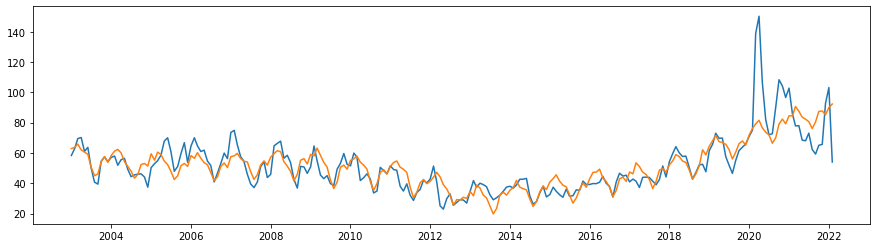

In [85]:
# Obtener modelo con Fbprophet usando todas las variables exógenas (salvo COVID)
#instanciamos prophet
model6=Prophet() 
#transformación requerida
prf=ts.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
#anadimos la exógena
model6.add_regressor('Plantilla')
#model6.add_regressor('casos_covid')
model6.add_regressor('Festivos_intersemanales')
model6.add_regressor('busquedas_google')
model6.add_regressor('cambio_normativa')
#entrenamos modelo
model6.fit(prf)
#obtenemos valores de predicciones
yhat=model6.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts['Plantilla_de_baja'])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET3=get_error_percentage(ts['Plantilla_de_baja'],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET3}'

In [86]:
#Clasificamos modelo
tuple=('model6','Prophet con todos los exógenos (menos COVID)',porc_error_PROPHET3,'')
ranking_modelos.append(tuple)

### Conclusiones

In [110]:
ranking=pd.DataFrame(ranking_modelos, columns =['Modelo', 'Descripción', 'Score','Sparams']).sort_values(by='Score')
ranking

,Modelo,Descripción,Score,Sparams
3,smodel3b,Sarimax con exógeno plantilla y casos_covid,0.141948,"(1, 1, 5, 12)"
7,smodel5,Sarimax con todos los exógenos,0.143277,"(1, 1, 5, 12)"
4,smodel4,Sarimax con todos los exógenos (menos casos_co...,0.146623,"(1, 1, 5, 12)"
2,smodel3,Sarimax con exógeno plantilla,0.151552,"(1, 1, 5, 12)"
0,smodel1,Sarimax sin exógenos,0.156510,"(1, 1, 5, 12)"
6,model6,Prophet con todos los exógenos (menos COVID),0.198415,
5,model5,Prophet con exógeno plantilla,0.201917,
1,model2,Prophet sin exógenos,0.203206,


In [116]:
print(f'El primer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel3b.exog_names} y parámetros {smodel3b.seasonal_order}')
print(f'El segundo mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel5.exog_names} y parámetros {smodel5.seasonal_order}')
print(f'El tercer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de {smodel4.exog_names} y parámetros {smodel4.seasonal_order}')

El primer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Plantilla', 'casos_covid'] y parámetros (1, 1, 5, 12)
El segundo mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Festivos_intersemanales', 'Plantilla', 'casos_covid', 'busquedas_google', 'cambio_normativa'] y parámetros (1, 1, 5, 12)
El tercer mejor modelo de acuerdo al criterio del error cuadrático medio es el SARIMAX con las variables exógenas de ['Festivos_intersemanales', 'Plantilla', 'busquedas_google', 'cambio_normativa'] y parámetros (1, 1, 5, 12)


## Modelos para predecir variables exógenas

### Plantilla

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1947.831, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2022.811, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2016.891, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2011.334, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2023.875, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2002.987, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2002.063, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1948.328, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1948.322, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2011.583, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1993.125, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2002.293, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1949.879, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1949.340, Time=0.61 sec

Best model:  ARIMA(2,1,2)(0,0,0)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (2, 1, 2, 12) y un porcentaje de error del 0.031191681757506404'

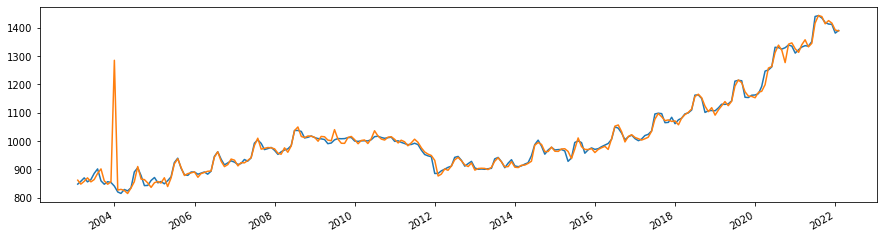

In [89]:
#Obtener mejor modelo de Arima
model7=auto_arima(ts[['Plantilla']], trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model7.order 
sparams = model7.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel7 = SARIMAX(ts[['Plantilla']], 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results7=smodel7.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts[['Plantilla']][1:])
y_pred_model7=results7.get_prediction(start='2003-02-01',end='2022-02-01').predicted_mean
y_pred_model7.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts[['Plantilla']][1:],y_pred_model7)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.01707449110200554'

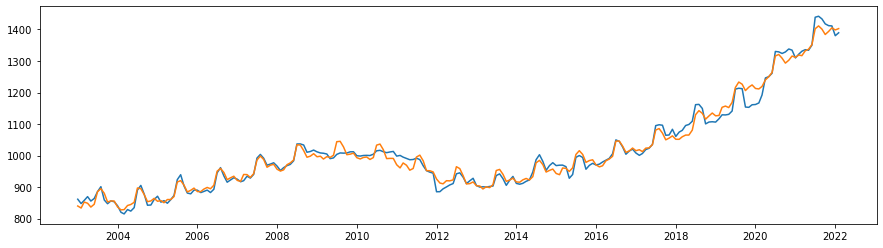

In [90]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model8=Prophet() 
#transformación requerida
prf=ts[['Plantilla']].reset_index().rename(columns={'date':'ds','Plantilla':'y'}) 
#entrenamos modelo
model8.fit(prf)
#obtenemos valores de predicciones
yhat=model8.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts[['Plantilla']])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts[['Plantilla']],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

### Casos_covid

In [34]:
#Importamos dataset casos covid
df_covid = pd.read_csv('data/casos_covid.csv', sep=',',encoding='latin1')

In [35]:
#transformación
df_covid['date']=df_covid.date.astype('datetime64[ns]')


#### Arima

In [36]:
ts_covid=df_covid.set_index('date')

In [37]:
#Obtener mejor modelo de Arima
model9=auto_arima(ts_covid, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=537.945, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=535.279, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=534.658, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=534.309, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=540.578, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=536.120, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=536.246, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=537.026, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=535.647, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.251 seconds


<AxesSubplot:>

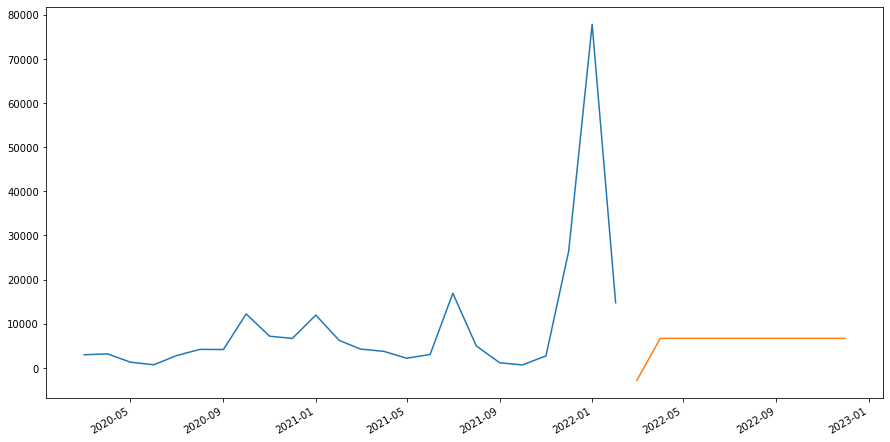

In [38]:
#creamos una serie para darle un indice
pred=model9.predict(n_periods=10)
plt.plot(ts_covid)
pd.Series(pred, index=pd.date_range(start='2022-03-01', end='2022-12-01', freq='MS')).plot()

#### FbProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.0423297814138255'

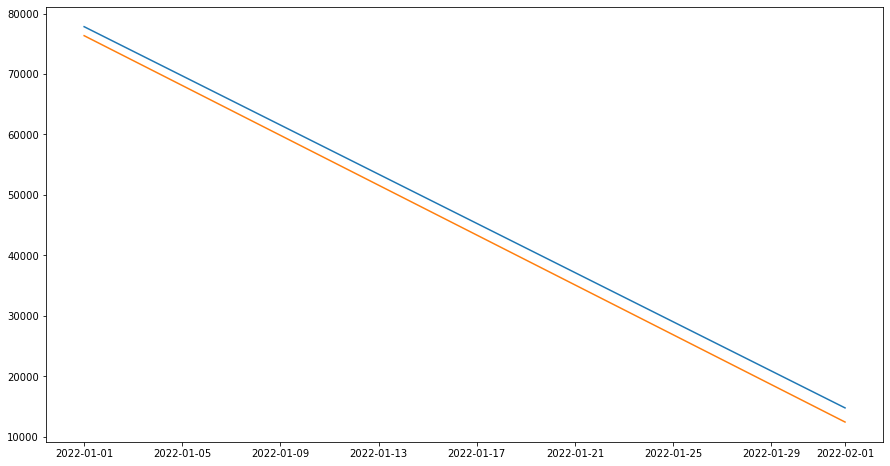

In [40]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model9=Prophet(growth='linear') 
#transformación requerida
prf=ts_covid[-2:].reset_index().rename(columns={'date':'ds','numcasos':'y'})
#prf['cap']=78000
#entrenamos modelo
model9.fit(prf)
#obtenemos valores de predicciones
yhat=model9.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2022-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_covid[-2:])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_covid[-2:],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'


In [41]:
ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})

In [42]:
model9.predict(ds).yhat

0    -45282.219290
1   -109181.641080
2   -171019.791199
3   -234919.212988
4   -296757.363107
5   -360656.784896
6   -424556.206686
7   -486394.356804
8   -550293.778594
9   -612131.928713
Name: yhat, dtype: float64

In [ ]:
#Conclusión => con los métodos que conocemos no es posible predicir la evolución de los datos covid

### Búsquedas Google

In [92]:
ts_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1625.170, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1659.389, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1659.019, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1654.522, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1657.395, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1624.066, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1627.377, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1625.283, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1638.447, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1623.214, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1625.946, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1626.9

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 2, 12) y un porcentaje de error del 0.4558278903009196'

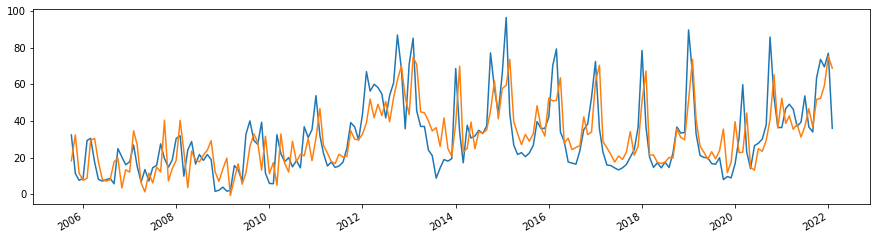

In [98]:
#Obtener mejor modelo de Arima
model10=auto_arima(ts_google, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model10.order 
sparams = model10.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel10 = SARIMAX(ts_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results10=smodel10.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts_google[1:])
y_pred_model10=results10.get_prediction(start='2005-10-01',end='2022-02-01').predicted_mean
y_pred_model10.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_google[1:],y_pred_model10)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


get_error_percentage() method was called.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.5435460099186874'

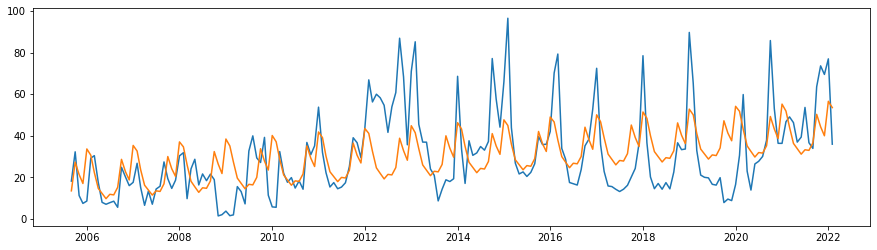

In [102]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model11=Prophet() 
#transformación requerida
prf=ts_google.reset_index().rename(columns={'date':'ds','busquedas_google':'y'}) 
#entrenamos modelo
model11.fit(prf)
#obtenemos valores de predicciones
yhat=model11.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2005-09-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_google)
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_google,y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

## Modelos predictivos sin contar con meses COVID

In [68]:
ts_sin_COVID=ts.reset_index()
ts_sin_COVID=ts_sin_COVID[ts_sin_COVID['date']<'2020-03-01'].set_index('date').drop('casos_covid',axis=1)

In [69]:
ts_sin_COVID

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google,cambio_normativa
date,,,,,
2003-01-01,2,861.654839,58.322581,18.498320,0
2003-02-01,1,847.775357,63.000000,28.815873,0
2003-03-01,0,857.704194,69.477419,18.483871,0
2003-04-01,2,869.806667,70.153333,17.166667,0
2003-05-01,1,855.794839,61.032258,15.784946,0
...,...,...,...,...,...
2019-10-01,0,1154.029032,61.575484,7.935484,0
2019-11-01,1,1153.076667,63.826000,9.400000,0
2019-12-01,3,1161.255161,65.869355,9.000000,0


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1300.055, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1343.228, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1344.223, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1343.219, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1341.262, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1318.310, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1333.039, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1321.701, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1314.358, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1342.769, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1317.383, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1328.527, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1298.808, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1285.424, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


get_error_percentage() method was called.


'El mejor modelo SARIMAX tiene unos parámetros de (5, 1, 3, 12) y un porcentaje de error del 0.11098154645623179'

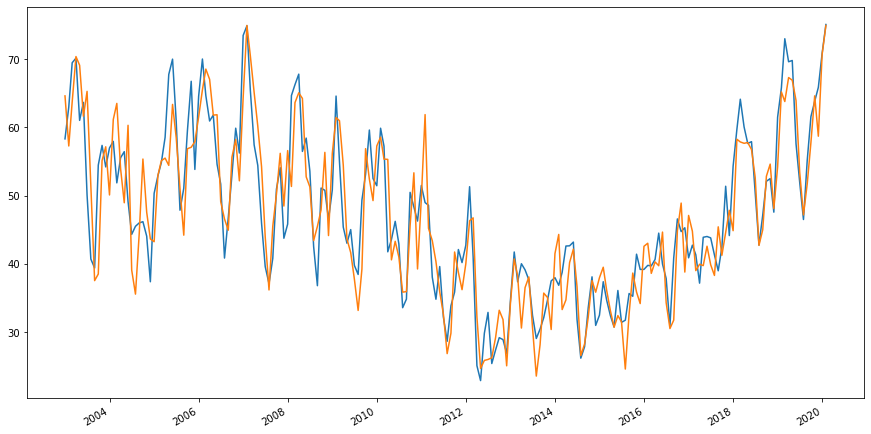

In [114]:
#Obtener mejor modelo de Arima
#Usamos como variables exógenas las sugeridas por random forest (No incluimos casos_covid porque no se puede predecir)
exogenas=ts_sin_COVID[['Plantilla']]
model10=auto_arima(ts_sin_COVID[['Plantilla_de_baja']],exog=exogenas, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model10.order 
sparams = model10.order+(12,) 
#freq MS quiere decir frecuencia mensual

smodel10 = SARIMAX(ts_sin_COVID[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

results10=smodel10.fit(maxiter=1000)

#intentamos hacer una prediccion de los datos  a partir de nuestro modelo
plt.plot(ts_sin_COVID['Plantilla_de_baja'])
y_pred_SAR10=results10.get_prediction(start='2003-01-01',end='2020-02-01').predicted_mean
y_pred_SAR10.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_sin_COVID[['Plantilla_de_baja']],y_pred_SAR10)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'


In [115]:
exogeno1=ts[['Plantilla']].reset_index().rename(columns={'date':'ds'}).set_index('ds')

In [116]:
ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})
'''yhat_plantilla=pd.Series(modelo_plantilla_profet.predict(ds).yhat,
                         index=pd.date_range(start='2022-02-01',
                                  end='2022-12-01',
                                  freq='MS'))'''
yhat=model8.predict(ds).yhat
exogeno2=pd.DataFrame(data=yhat.to_numpy(),index=ds['ds'],columns=['Plantilla'])

In [117]:
exogeno=exogeno1.append(exogeno2)
exogeno=exogeno[-34:] #se añade los valores de la pandemia

<AxesSubplot:>

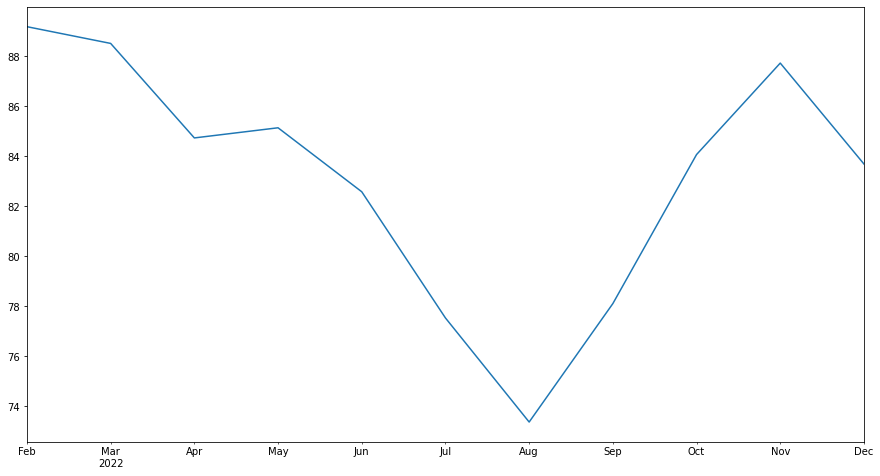

In [118]:
y_pred_inf=results10.get_prediction(start='2022-02-01',end='2022-12-01',exog=exogeno).predicted_mean
y_pred_inf.plot()

## Exportar modelos

Decidimos exportar el terce modelo con mejor score (smodel4) porque evita tener que predecir la variable exógena "casos_covid".

Para usar el modelo debemos exportar:
* Modelo ARIMA 
* Modelo Prophet para predecir variable exógena de Plantilla
* Modelo ARIMA para predecir variable de búsquedas google
* Dataset con datos históricos para entrenas modelos ARIMA

In [103]:
import pickle

In [104]:
#Exportamos el segundo mejor modelo porque éste no requiere predecir los casos covid
with open('models/model_enfermeras.pkl','wb') as f:
    pickle.dump(model4,f)

In [105]:
#Modelo Prophet para predecir variable exógena de Plantilla
with open('models/model_enfermeras_plantilla.pkl','wb') as f:
    pickle.dump(model8,f)

In [107]:
#Modelo Arima para predecir variable exógena de búsquedas_google
with open('models/model_enfermeras_google.pkl','wb') as f:
    pickle.dump(model10,f)

## Otros

In [119]:
#Exportamos el model sin tener en cuenta la pandemia
#with open('models/model_enfermeras_sin_covid.pkl','wb') as f:
#    pickle.dump(smodel10,f)

In [50]:
ts_it.tail(12) #las predicciones con pandemia me salen disparadas

,Plantilla_de_baja
date,
2021-03-01,77.846129
2021-04-01,77.978333
2021-05-01,68.478065
2021-06-01,67.994333
2021-07-01,73.054194
2021-08-01,62.301290
2021-09-01,59.239667
2021-10-01,65.073548
2021-11-01,65.600333


In [43]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras2.pkl','wb') as f:
 #   pickle.dump(model3,f)

In [46]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras3.pkl','wb') as f:
#    pickle.dump(model3b,f)